In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
# Grab and look at our data
DATA_LOCATION = 'AirPassengers.csv'
data = pd.read_csv(DATA_LOCATION)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Convert to DateTime
data["Month"] = pd.to_datetime(data.Month)
data.set_index('Month', inplace=True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# Time series in numpy format
np_ts = np.array(data).reshape(144)

# Time series in pandas format
pd_ts = data.copy()

C:\Users\TSB\Miniconda3\envs\myenv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


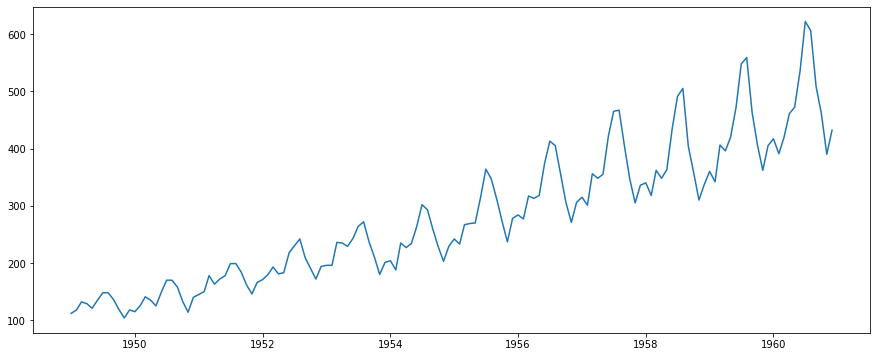

In [5]:
plt.plot(pd_ts)

In [6]:
# Split up our dataset
split_time = 100
x_train = np_ts[:split_time]
x_valid = np_ts[split_time:]

# Naive Forecasting

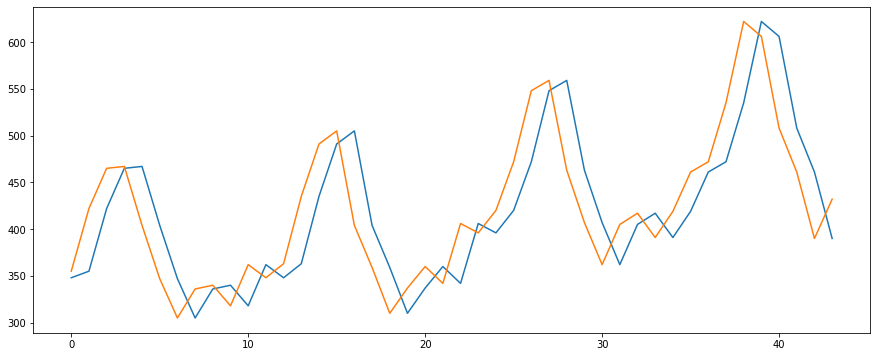

In [7]:
# Naive forecasting
naive_forecast = np_ts[split_time - 1:-1]
plt.plot(naive_forecast)
plt.plot(x_valid)

In [8]:
# Calculate our Mean Average Error as a baseline
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = np.mean(abs_errors)
mae

41.72727272727273

# Dense Model Forecasting

In [9]:
# Utils

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
keras = tf.keras

# Create Windowed Datasets
window_size = 20
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# Simple Dense Model Forecasting
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
3/3 [==============================] - 0s 82ms/step - loss: 271.8661 - mae: 272.3661 - val_loss: 505.8083 - val_mae: 506.3083
Epoch 2/500
3/3 [==============================] - 0s 13ms/step - loss: 264.9019 - mae: 265.4019 - val_loss: 484.3098 - val_mae: 484.8098
Epoch 3/500
3/3 [==============================] - 0s 13ms/step - loss: 252.7449 - mae: 253.2449 - val_loss: 459.5409 - val_mae: 460.0409
Epoch 4/500
3/3 [==============================] - 0s 15ms/step - loss: 240.2713 - mae: 240.7713 - val_loss: 445.2593 - val_mae: 445.7593
Epoch 5/500
3/3 [==============================] - 0s 15ms/step - loss: 234.7380 - mae: 235.2380 - val_loss: 439.4569 - val_mae: 439.9569
Epoch 6/500
3/3 [==============================] - 0s 11ms/step - loss: 232.3914 - mae: 232.8914 - val_loss: 434.1690 - val_mae: 434.6690
Epoch 7/500
3/3 [==============================] - 0s 12ms/step - loss: 229.5039 - mae: 230.0039 - val_loss: 428.0587 - val_mae: 428.5587
Epoch 8/500
3/3 [=================

3/3 [==============================] - 0s 11ms/step - loss: 20.0211 - mae: 20.5187 - val_loss: 43.2069 - val_mae: 43.7047
Epoch 62/500
3/3 [==============================] - 0s 10ms/step - loss: 20.0685 - mae: 20.5667 - val_loss: 42.7780 - val_mae: 43.2549
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 19.7746 - mae: 20.2746 - val_loss: 41.1488 - val_mae: 41.6488
Epoch 64/500
3/3 [==============================] - 0s 11ms/step - loss: 19.4789 - mae: 19.9751 - val_loss: 39.9085 - val_mae: 40.4085
Epoch 65/500
3/3 [==============================] - 0s 12ms/step - loss: 19.8853 - mae: 20.3800 - val_loss: 39.9053 - val_mae: 40.4053
Epoch 66/500
3/3 [==============================] - 0s 10ms/step - loss: 19.7656 - mae: 20.2585 - val_loss: 41.1507 - val_mae: 41.6507
Epoch 67/500
3/3 [==============================] - 0s 11ms/step - loss: 19.4631 - mae: 19.9609 - val_loss: 41.0337 - val_mae: 41.5337
Epoch 68/500
3/3 [==============================] - 0s 11ms/step - l

3/3 [==============================] - 0s 11ms/step - loss: 15.7665 - mae: 16.2566 - val_loss: 31.5247 - val_mae: 32.0247
Epoch 122/500
3/3 [==============================] - 0s 11ms/step - loss: 15.7876 - mae: 16.2771 - val_loss: 34.1970 - val_mae: 34.6970
Epoch 123/500
3/3 [==============================] - 0s 10ms/step - loss: 15.8239 - mae: 16.3205 - val_loss: 29.7869 - val_mae: 30.2848
Epoch 124/500
3/3 [==============================] - 0s 11ms/step - loss: 15.9011 - mae: 16.3986 - val_loss: 28.9909 - val_mae: 29.4909
Epoch 125/500
3/3 [==============================] - 0s 10ms/step - loss: 15.8517 - mae: 16.3455 - val_loss: 30.7543 - val_mae: 31.2543
Epoch 126/500
3/3 [==============================] - 0s 11ms/step - loss: 15.5239 - mae: 16.0134 - val_loss: 34.1309 - val_mae: 34.6309
Epoch 127/500
3/3 [==============================] - 0s 11ms/step - loss: 15.7893 - mae: 16.2857 - val_loss: 30.1250 - val_mae: 30.6233
Epoch 128/500
3/3 [==============================] - 0s 11ms/s

3/3 [==============================] - 0s 10ms/step - loss: 13.5694 - mae: 14.0694 - val_loss: 25.8322 - val_mae: 26.3154
Epoch 182/500
3/3 [==============================] - 0s 10ms/step - loss: 13.2000 - mae: 13.6992 - val_loss: 24.1472 - val_mae: 24.6472
Epoch 183/500
3/3 [==============================] - 0s 10ms/step - loss: 13.4243 - mae: 13.9072 - val_loss: 23.8955 - val_mae: 24.3892
Epoch 184/500
3/3 [==============================] - 0s 10ms/step - loss: 13.0042 - mae: 13.5026 - val_loss: 25.4790 - val_mae: 25.9790
Epoch 185/500
3/3 [==============================] - 0s 10ms/step - loss: 13.9159 - mae: 14.4128 - val_loss: 28.5987 - val_mae: 29.0987
Epoch 186/500
3/3 [==============================] - 0s 10ms/step - loss: 13.5712 - mae: 14.0610 - val_loss: 24.1575 - val_mae: 24.6534
Epoch 187/500
3/3 [==============================] - 0s 10ms/step - loss: 13.3716 - mae: 13.8569 - val_loss: 23.7050 - val_mae: 24.2049
Epoch 188/500
3/3 [==============================] - 0s 10ms/s

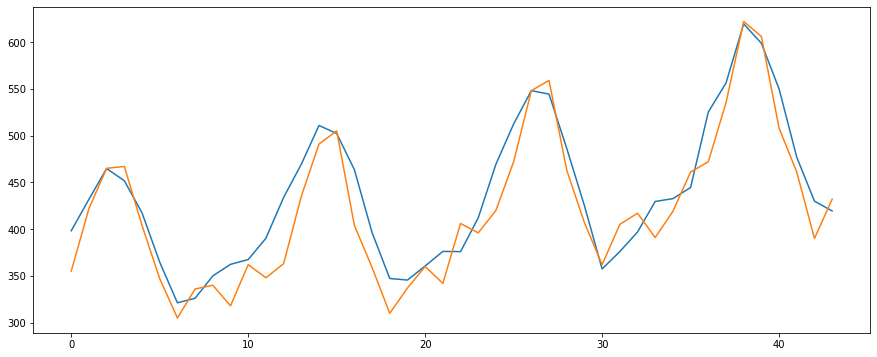

In [11]:
# Get our predictions
dense_forecast = model_forecast(
    model,
    np_ts[split_time - window_size:-1],
    window_size)[:, 0]

plt.plot(dense_forecast)
plt.plot(x_valid)

In [12]:
# MAE for validation set using a simple Dense model (already much better than baseline)
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

23.682121

# RNNS using Pandas

In [13]:
df = pd_ts

In [14]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [15]:
data = df.values

In [25]:
SPLIT_TIME = 100
train_mean = data[:SPLIT_TIME].mean()
train_std = data[:SPLIT_TIME].std()
print("Training Mean Is:", train_mean)
print("Training Std Is:", train_std)

Training Mean Is: 218.36
Training Std Is: 73.84842855470927


In [26]:
standardized_data = (data - train_mean) / train_std

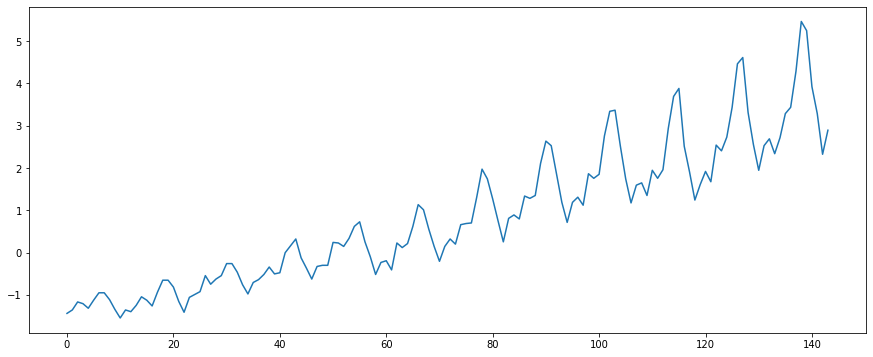

In [29]:
plt.plot(standardized_data)

In [38]:
def windowed_data(data, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(data[indices], (history_size, 1)))
        labels.append(data[i+target_size])
        
    return np.array(data), np.array(labels)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [52]:
HISTORY_SIZE = 10
TARGET_SIZE = 0

x_train, y_train = univariate_data(standardized_data[:SPLIT_TIME],
                        0,
                        SPLIT_TIME,
                        HISTORY_SIZE,
                        TARGET_SIZE)

x_val, y_val = univariate_data(standardized_data[SPLIT_TIME:],
                        SPLIT_TIME,
                        44,
                        HISTORY_SIZE,
                        TARGET_SIZE)



In [54]:
print(x_train.shape)
print(x_val.shape)
print(standardized_data[SPLIT_TIME:].shape)

# TOSO FIX X_VAL EMPTY DATA

(90, 10, 1)
(0,)
(44, 1)
